# 0. Settings

In [ ]:
model_distributer = "meta-llama"
model_name = "Llama-3.1-8B"
root_path = "./data"
save_path = root_path +"/"+ model_name.lower()
dataset = ["CommonsenseQA_test.jsonl",]
dataset_path = root_path + "/" + dataset[0]


In [ ]:
save_path

'/content/drive/MyDrive/KAIRI_Experiment/Prompt_Bias/olmo-7b-0724-instruct-hf'

# 1. 🗞 Data and Prompts

## Import Data

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
!pip install jsonlines

In [ ]:
import jsonlines

In [ ]:
data = []
with jsonlines.open(dataset_path) as json_file:
  for line in json_file:
    data.append(line)

## Make prompts

In [ ]:
prompts = [
"""question:{question}
options:{options}
answer:""",
"""Question:{question}
Options:{options}
Answer:""",
"""QUESTION:{question}
OPTIONS:{options}
ANSWER:""",
""" question: {question}
 options: {options}
 answer:""",
""" Question: {question}
 Options: {options}
 Answer:""",
""" QUESTION: {question}
 OPTIONS: {options}
 ANSWER:""",]

# 2. 👽 Model

In [ ]:
import transformers
from transformers import AutoTokenizer, LlamaForCausalLM, AutoModelForCausalLM
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if "Llama" in model_name:
  model = LlamaForCausalLM.from_pretrained(model_distributer+"/"+model_name, torch_dtype=torch.float16)
elif "gemma" in model_name:
  model = AutoModelForCausalLM.from_pretrained(model_distributer+"/"+model_name, torch_dtype=torch.float16)
else:
  try:
    model = AutoModelForCausalLM.from_pretrained(model_distributer+"/"+model_name, torch_dtype=torch.float16)
  except:
    raise ValueError("The model is not supported.")
tokenizer = AutoTokenizer.from_pretrained(model_distributer+"/"+model_name)
model.to(device)
model_unembed = model.lm_head

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# 3. Functions

## 3-1. Common Functions

In [ ]:
from typing import Any, Dict, List, Union, Tuple, Optional
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import jsonlines
from collections import Counter
from tqdm.auto import tqdm

In [ ]:
def apply_content(template: str, content: dict) -> str:
  """
  Fills a specified prompt template with content from a single data entry
  (e.g., from a JSON Lines file).

  Args:
      template (str): A string template selected from multiple prompt candidates.
                      This template must contain {question} and {options} placeholders.
      content (dict): A JSON object read from a line in a .jsonl file,
                      containing information like questions and choices.

  Returns:
      str: The completed prompt string with content applied.
  """
  # Extract the question text from the content dictionary.
  question = content["questions"]["original"]

  # Create the options list string using the 'options' list from content.
  # Example: "\nA. Answer 1\nB. Answer 2"
  options_str = "".join(
      f"\n{option['label']}. {option['text']}" for option in content["options"]
  )

  # Replace the template's placeholders with the actual content and return the final string.
  return template.format(question=question, options=options_str)

In [ ]:
def make_tokenized_prompts(
    templates: List[str],
    json_data: Dict,
    tokenizer: AutoTokenizer = tokenizer,
    device: torch.device = device
) -> List[Dict]:
    """
    Applies json_data to a list of prompt templates and tokenizes each result.

    Args:
        templates (List[str]): A list of prompt templates to be filled.
        json_data (Dict): The JSON object containing data to fill into the prompts.
        tokenizer (AutoTokenizer): The tokenizer object to use.
        device (torch.device): The device to move the tokenized tensors to.

    Returns:
        List[Dict]: A list of tokenized prompt tensors (as dictionaries from the tokenizer).
    """
    return [
        tokenizer(apply_content(template, json_data), return_tensors = "pt").to(device)
        for template in templates
    ]

In [ ]:
def process_data(
    model: Any, # PreTrainedModel
    tokenized_prompts: List[Dict[str, Any]], # torch.Tensor
) -> Dict[str, Dict[int, List[float]]]:
  """
  Runs the model to extract the hidden states of the last token
  for each prompt across all layers.

  Args:
      model (transformers.PreTrainedModel):
          A pre-trained transformer model object from Hugging Face.
          Must support the `output_hidden_states=True` option.

      tokenized_prompts (List[Dict[str, torch.Tensor]]):
          A list of tokenized prompt data.
          Each element is a dictionary of the form `{'input_ids': torch.Tensor, ...}`.
          - Example: `[{'input_ids': tensor([[101, 2054, ...]])}, {'input_ids': tensor([[101, 2500, ...]])}]`

  Returns:
      Dict[str, Dict[int, List[float]]]:
          A dictionary containing the hidden states of the last token,
          organized by prompt and by layer.
          - Structure:
            {
                "Prompt_1": {
                    0: [0.1, 0.2, ...],  # Hidden state vector for layer 0
                    1: [0.3, 0.1, ...],  # Hidden state vector for layer 1
                    ...
                },
                "Prompt_2": { ... }
            }
  """
  hidden_states_contents = {}
  with torch.no_grad():
    for i, item in enumerate(tokenized_prompts):
      # Run the model
      outputs = model(item['input_ids'], output_hidden_states=True)

      # Use a dictionary comprehension to store the last token's hidden state for each layer
      # outputs.hidden_states is a tuple of hidden state tensors (one for each layer).
      # The shape of each tensor (hs) is (1, seq_len, dim),
      # so the hidden state for the last token is accessed via hs[0, -1] or hs[0][-1].
      hidden_states_contents[f"Prompt_{i+1}"] = {
          layer_idx: hs for layer_idx, hs in enumerate(outputs.hidden_states)
    }
  return hidden_states_contents

## 3-2. Analysis Function

In [ ]:
def plot_comparison_figures(
    consistent_data: Dict,
    inconsistent_data: Dict,
    num_layers: int,
    target_answer: str,
    output_prefix: str
):
    """Generates comparison graphs including standard deviation."""
    print(f"🎨 Plotting comparison with std dev for target answer '{target_answer}'...")

    for metric in ["Projected Logit", "Projected Probability"]:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        fig.suptitle(f"{metric.capitalize()} Analysis for Target Answer: '{target_answer}' (Mean ± Std Dev) ({model_name.lower()})", fontsize=18)

        # Left: Plot for Consistent data
        _plot_subplot(axes[0], consistent_data[metric], "Consistent Group", metric, num_layers)

        # Right: Plot for Inconsistent data
        _plot_subplot(axes[1], inconsistent_data[metric], "Inconsistent Group", metric, num_layers)

        # handles, labels = axes[0].get_legend_handles_labels()
        # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.95))

        fig.tight_layout(rect=[0, 0, 1, 0.96])
        output_filename = save_path + f"/Figure/{output_prefix}_normalized_target_{target_answer}_{metric}_comparison_with_std.png"
        plt.savefig(output_filename)
        plt.show()
        plt.close(fig)
    print(f"✅ Comparison plots for '{target_answer}' saved.")

In [ ]:
from collections import Counter
from typing import List, Optional

def get_majority_from_pregenerated(answers: List[str]) -> Optional[str]:
    """
    Takes a list of answers, normalizes them by stripping whitespace,
    and returns the majority answer if it has 4 or more votes.
    """
    if not answers or len(answers) < 4:
        return None

    # Normalize each answer by stripping surrounding whitespace. e.g., ' A' -> 'A'
    normalized_answers = [ans.strip('▁Ġ ') for ans in answers]

    # Count the votes based on the normalized answer list.
    vote_counts = Counter(normalized_answers)
    if not vote_counts:
        return None

    majority_vote, count = vote_counts.most_common(1)[0]

    return majority_vote if count >= 4 else None

In [ ]:
# [NEW] New function to determine consistency only if all 6 answers are identical
from typing import List, Optional

def get_unanimous_answer(answers: List[str]) -> Optional[str]:
    """
    Takes a list of answers (6), normalizes them, and checks if all 6 are identical.
    Returns the answer if unanimous, otherwise returns None.
    """
    # 1. Check if the answer list has exactly 6 items
    if not answers or len(answers) != 6:
        return None

    # 2. Normalize each answer by stripping whitespace
    normalized_answers = [ans.strip(' Ġ▁') for ans in answers]

    # 3. Convert to a set to check the number of unique answers
    unique_answers = set(normalized_answers)

    # 4. Judge as unanimous only if there is exactly one unique answer
    if len(unique_answers) == 1:
        return normalized_answers[0]  # Return the unanimous answer
    else:
        return None # Return None if not unanimous

In [ ]:
def analyze_topk_logits_and_probs(
    model: Any,
    data_point: Dict,
    templates: List[str],
    tokenizer: Any,
    device: torch.device,
    k: int = 5
) -> Dict[str, Dict[str, Dict[str, List[float]]]]:
    """
    For each prompt, identifies the top-k predicted tokens at the final layer
    and extracts their logit and probability trajectories across all layers.
    """
    hidden_states_by_prompt = process_data(model, make_tokenized_prompts(templates, data_point, tokenizer, device))
    analysis_results = {}

    unembedding_layer = model.lm_head
    norm_layer = model.model.norm
    original_dtype = unembedding_layer.weight.dtype

    try:
        unembedding_layer.to(torch.float32)
        norm_layer.to(torch.float32)

        for prompt_name, layers_dict in hidden_states_by_prompt.items():
            # Step 1: Identify the top K token IDs from the final layer's output.
            num_layers = len(layers_dict)
            final_hidden_state = layers_dict[num_layers - 1].to(torch.float32)
            final_normalized_hs = norm_layer(final_hidden_state)
            final_logits = unembedding_layer(final_normalized_hs)

            # Use torch.topk to find the k highest logit values and their indices.
            topk_results = torch.topk(final_logits[0, -1, :], k)
            topk_token_ids = topk_results.indices

            # Step 2: Prepare data structure to store trajectories keyed by rank.
            prompt_data = {
                "Projected Logit": {f"Rank {i+1}": [] for i in range(k)},
                "Projected Probability": {f"Rank {i+1}": [] for i in range(k)}
            }

            # Step 3: Iterate through all layers to build the trajectories for the top-k tokens.
            for layer_idx in sorted(layers_dict.keys()):
                h_k = layers_dict[layer_idx].to(torch.float32)
                normalized_h_k = norm_layer(h_k)
                all_logits = unembedding_layer(normalized_h_k)
                all_probs = F.softmax(all_logits, dim=-1)

                # For each of the top-k tokens, get its logit and prob from the current layer.
                for i, token_id in enumerate(topk_token_ids):
                    rank_label = f"Rank {i+1}"
                    prompt_data["Projected Logit"][rank_label].append(all_logits[0][-1][token_id].item())
                    prompt_data["Projected Probability"][rank_label].append(all_probs[0][-1][token_id].item())

            analysis_results[prompt_name] = prompt_data

    finally:
        unembedding_layer.to(original_dtype)
        norm_layer.to(original_dtype)

    return analysis_results

In [ ]:
def _plot_subplot(ax: plt.Axes, data_stats: Dict, title: str, metric: str, num_layers: int):
    """Helper function to plot mean and standard deviation for each rank."""
    ax.set_title(title, fontsize=14)
    layers_x_axis = range(num_layers)

    # Each 'token' is now a rank label, e.g., "Rank 1"
    for rank_label, stats in data_stats.items():
        mean = stats["mean"]
        std = stats["std"]

        line, = ax.plot(layers_x_axis, mean, marker='o', markersize=4, linestyle='-', label=f"{rank_label}")

        ax.fill_between(
            layers_x_axis,
            mean - std,
            mean + std,
            alpha=0.2,
            color=line.get_color()
        )

    ax.set_xlabel("Layer Number")
    ax.set_ylabel(f"{metric} Value")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    # The legend title is changed to be more descriptive of the ranking.
    ax.legend(title="Prediction Rank")

In [ ]:
def main_analysis_pipeline(
    model: Any,
    tokenizer: Any,
    all_data_by_id: Dict[str, Dict],
    generated_answers: Dict[str, Dict],
    consistent_ids: List[str],
    inconsistent_ids: List[str],
    templates: List[str],
    target_answer_tokens: List[str],
    device: torch.device,
    k_value: int = 5
):
    """
    Performs top-k logit/prob analysis by collecting all results first and then
    calculating batch mean and standard deviation.
    """
    num_layers = model.config.num_hidden_layers + 1
    metrics_to_track = ["Projected Logit", "Projected Probability"]
    ranks_to_track = [f"Rank {i+1}" for i in range(k_value)]

    # This helper function now initializes lists to store all results.
    def get_empty_results_collector():
        """Initializes a data structure to collect all layer-wise results."""
        return {
            metric: {
                rank: [] for rank in ranks_to_track
            }
            for metric in metrics_to_track
        }

    # The main loop iterates through each possible correct answer to create data subsets.
    for target_answer in target_answer_tokens:
        # 1. Filter data IDs based on the "unanimous" or "majority" consistency logic.
        consistent_subset_ids = [
            data_id for data_id in consistent_ids
            if get_unanimous_answer(generated_answers.get(data_id, {}).get("answers", [])) == target_answer
        ]
        inconsistent_subset_ids = [
            data_id for data_id in inconsistent_ids
            if get_majority_from_pregenerated(generated_answers.get(data_id, {}).get("answers", [])) == target_answer
        ]

        print(f"\n--- Analysis for Target Answer Group: '{target_answer}' ---")
        print(f"Found {len(consistent_subset_ids)} consistent data points.")
        print(f"Found {len(inconsistent_subset_ids)} inconsistent data points.")

        final_stats = {}
        # 2. Process each group (consistent and inconsistent).
        for group_name, group_ids in [("consistent", consistent_subset_ids), ("inconsistent", inconsistent_subset_ids)]:
            if not group_ids:
                print(f"Skipping '{group_name}' group for target '{target_answer}' as it has no data.")
                # Initialize with empty stats if no data is present
                final_stats[group_name] = {m: {r: {"mean": np.zeros(num_layers), "std": np.zeros(num_layers)} for r in ranks_to_track} for m in metrics_to_track}
                continue

            # This collector will store all results (as NumPy arrays) for the group.
            group_collector = get_empty_results_collector()

            for data_id in tqdm(group_ids, desc=f"Analyzing {group_name} group for target '{target_answer}'"):
                data_point = all_data_by_id.get(data_id)
                if not data_point:
                    continue

                templates_for_analysis = templates

                # Call the analysis function to get results for one data point
                single_result = analyze_topk_logits_and_probs(
                    model, data_point, templates_for_analysis, tokenizer, device, k=k_value
                )

                for prompt_data in single_result.values():
                    for metric, rank_map in prompt_data.items():
                        for rank, new_values_list in rank_map.items():
                            # Append the layer-wise results as a NumPy array
                            group_collector[metric][rank].append(np.array(new_values_list, dtype=np.float64))

            group_stats = {m: {r: {"mean": np.zeros(num_layers), "std": np.zeros(num_layers)} for r in ranks_to_track} for m in metrics_to_track}
            for metric, rank_collector in group_collector.items():
                for rank, all_values in rank_collector.items():
                    # Check if we have collected any data for this rank
                    if all_values:
                        # Stack all arrays into a single 2D array (samples x layers)
                        all_values_np = np.stack(all_values)
                        # Calculate mean and std across all samples (axis=0) for each layer
                        group_stats[metric][rank]["mean"] = np.mean(all_values_np, axis=0)
                        group_stats[metric][rank]["std"] = np.std(all_values_np, axis=0)

            final_stats[group_name] = group_stats

        # 4. Call the plotting function with the calculated stats.
        if "consistent" in final_stats and "inconsistent" in final_stats:
            plot_comparison_figures(
                consistent_data=final_stats["consistent"],
                inconsistent_data=final_stats["inconsistent"],
                num_layers=num_layers,
                target_answer=target_answer, # Used for the plot title
                output_prefix=f"top_{k_value}_rank_analysis"
            )

# 4. Run

Step 1: Loading all data files...
Data loading complete.
Will create data groups for target answers: ['A', 'B', 'C', 'D', 'E']

--- Analysis for Target Answer Group: 'A' ---
Found 102 consistent data points.
Found 70 inconsistent data points.


Analyzing consistent group for target 'A':   0%|          | 0/102 [00:00<?, ?it/s]

Analyzing inconsistent group for target 'A':   0%|          | 0/70 [00:00<?, ?it/s]

🎨 Plotting comparison with std dev for target answer 'A'...


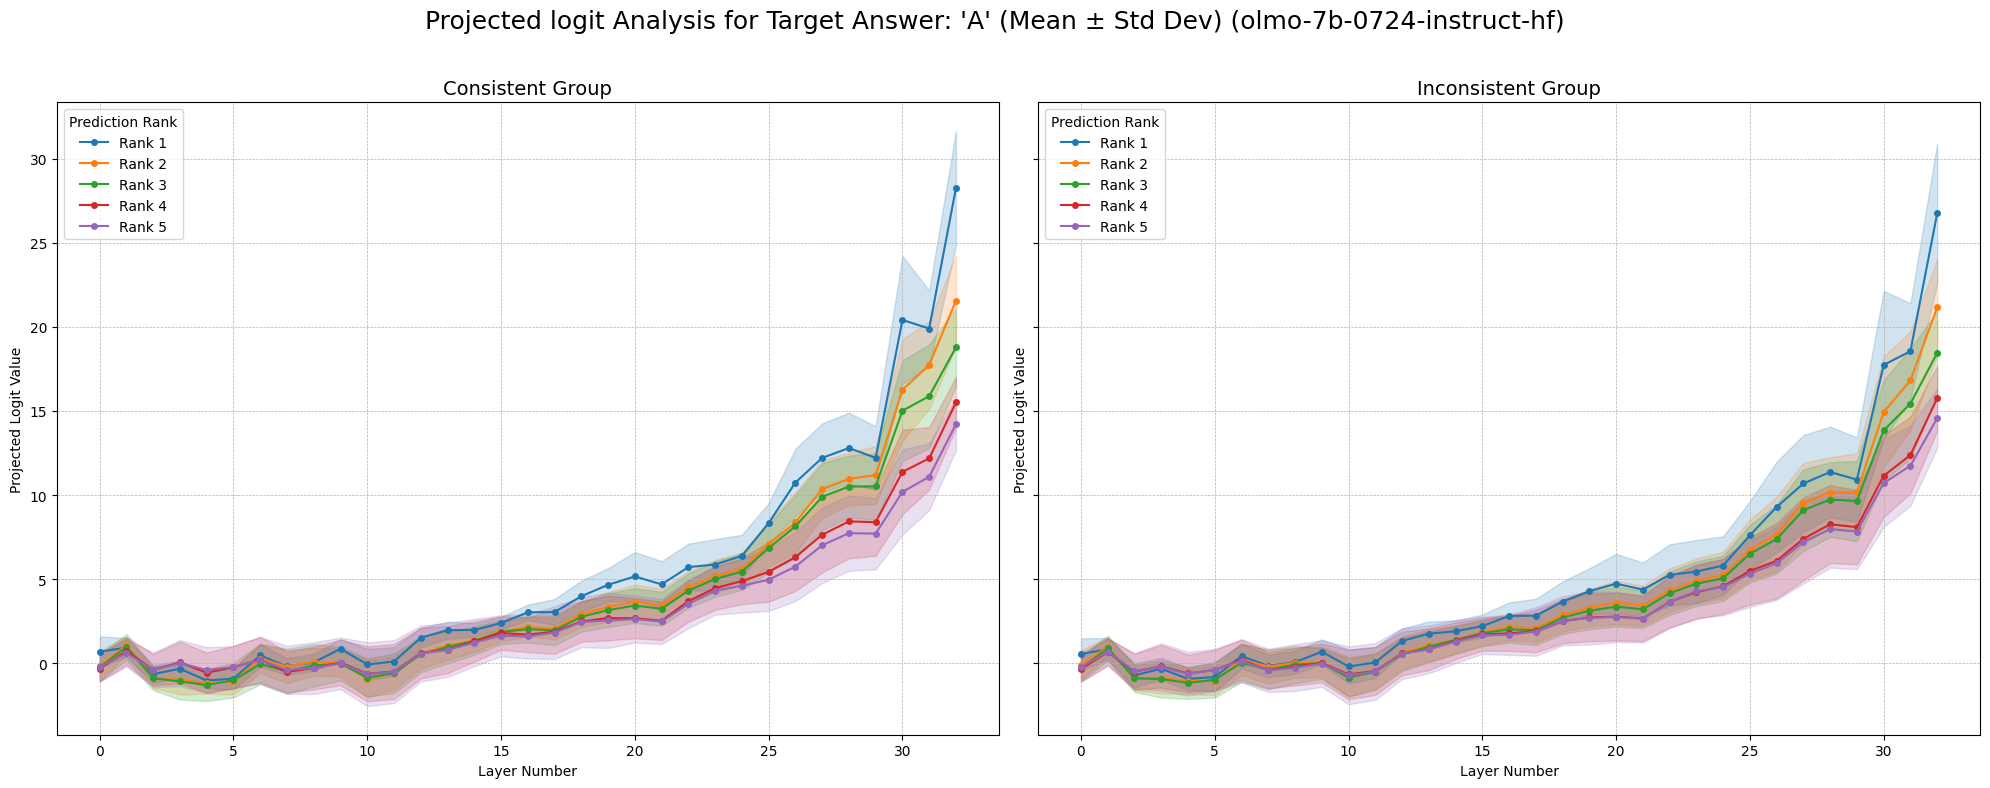

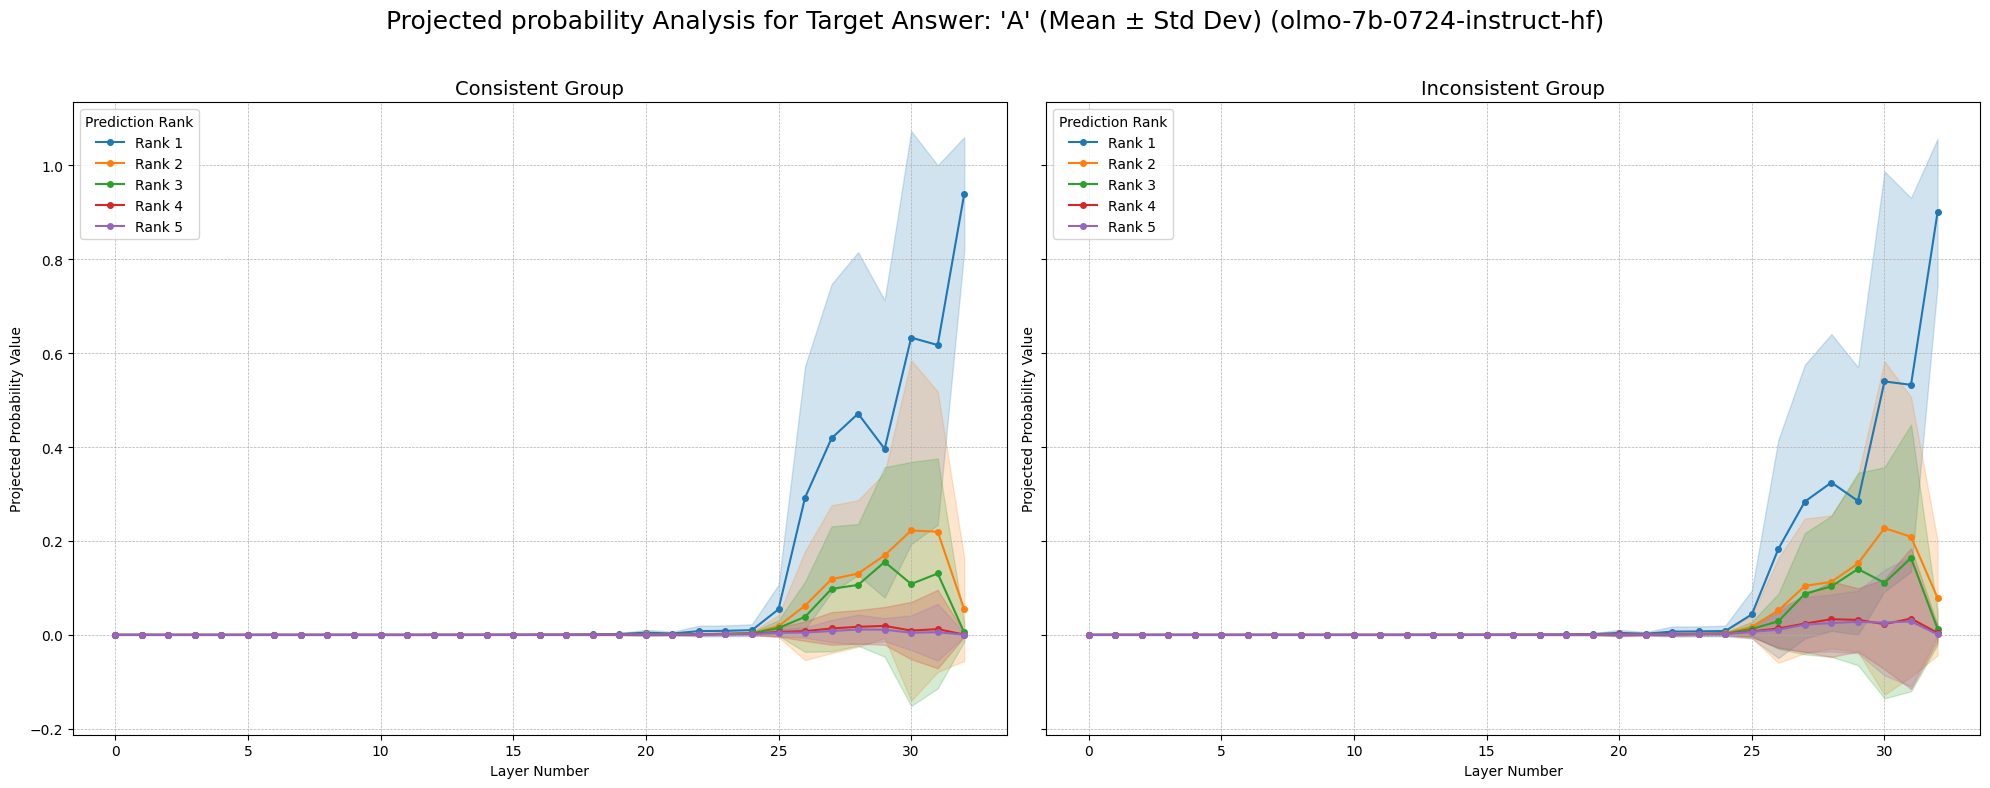

✅ Comparison plots for 'A' saved.

--- Analysis for Target Answer Group: 'B' ---
Found 126 consistent data points.
Found 57 inconsistent data points.


Analyzing consistent group for target 'B':   0%|          | 0/126 [00:00<?, ?it/s]

Analyzing inconsistent group for target 'B':   0%|          | 0/57 [00:00<?, ?it/s]

🎨 Plotting comparison with std dev for target answer 'B'...


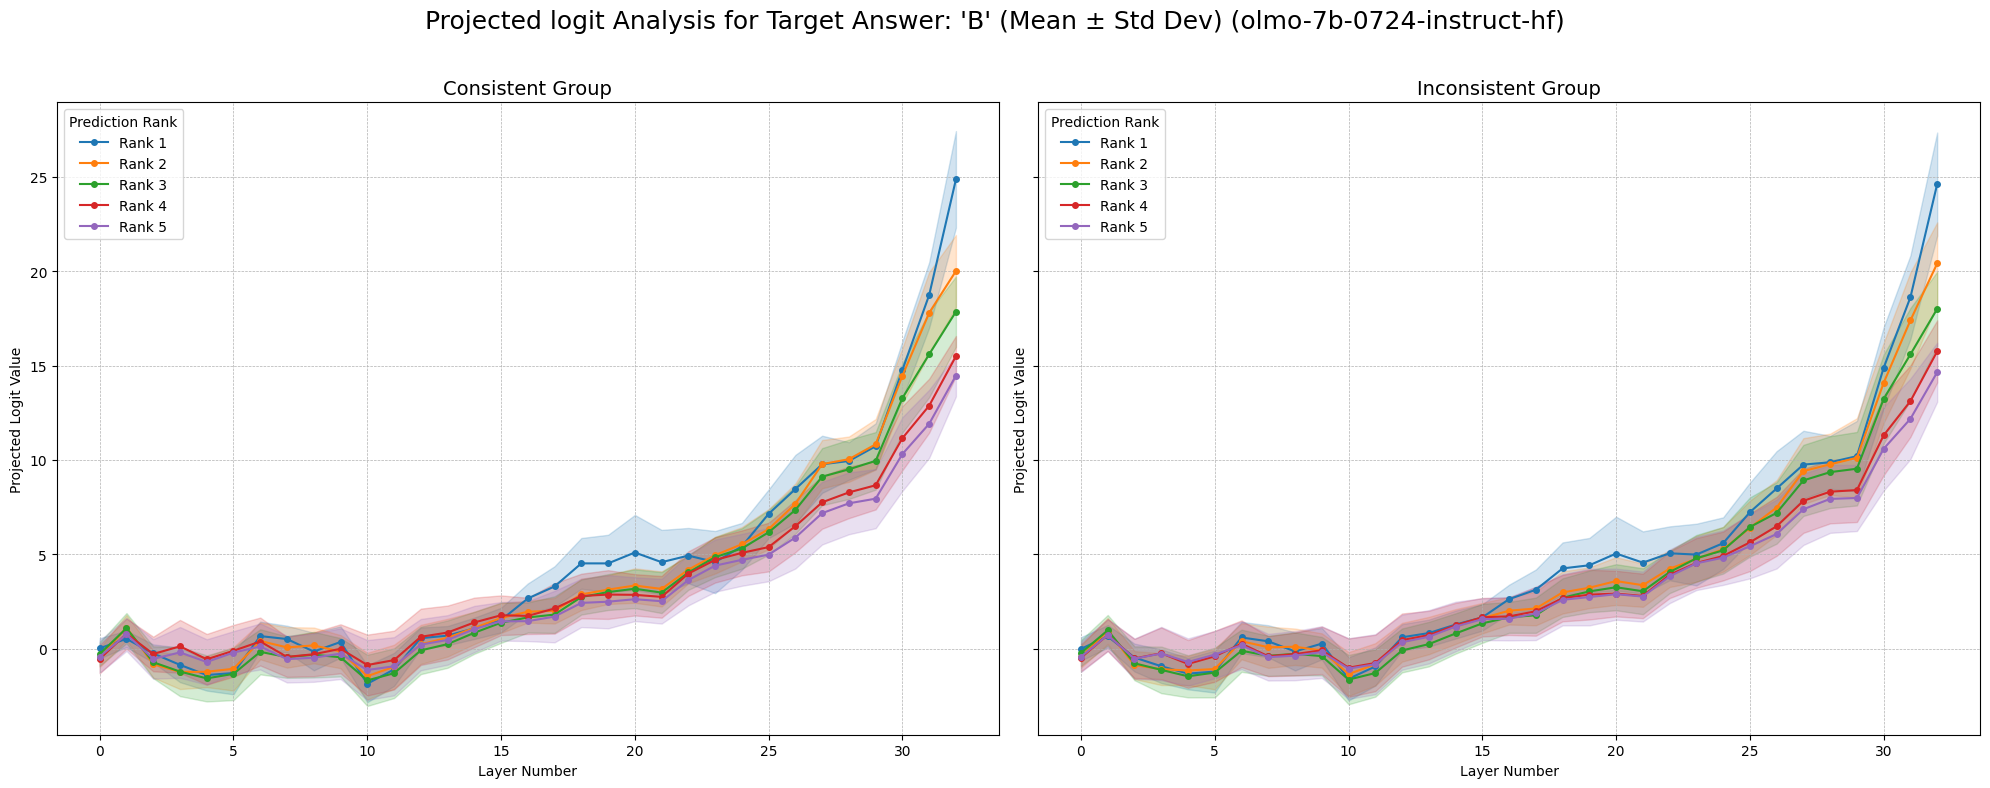

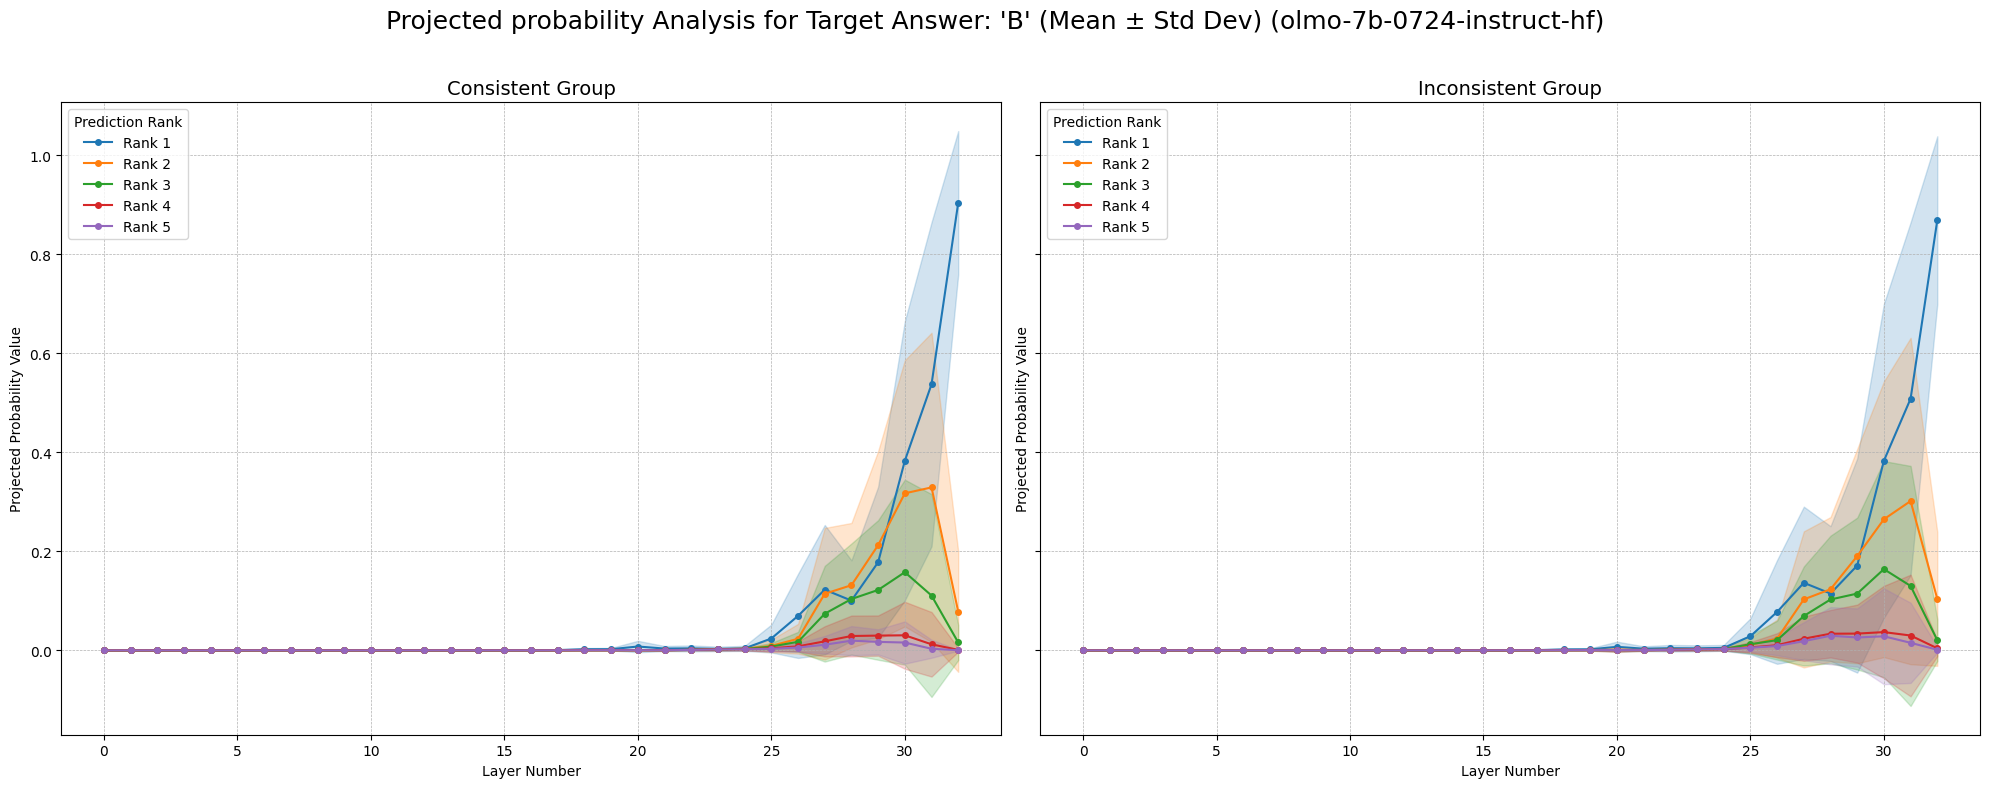

✅ Comparison plots for 'B' saved.

--- Analysis for Target Answer Group: 'C' ---
Found 151 consistent data points.
Found 31 inconsistent data points.


Analyzing consistent group for target 'C':   0%|          | 0/151 [00:00<?, ?it/s]

Analyzing inconsistent group for target 'C':   0%|          | 0/31 [00:00<?, ?it/s]

🎨 Plotting comparison with std dev for target answer 'C'...


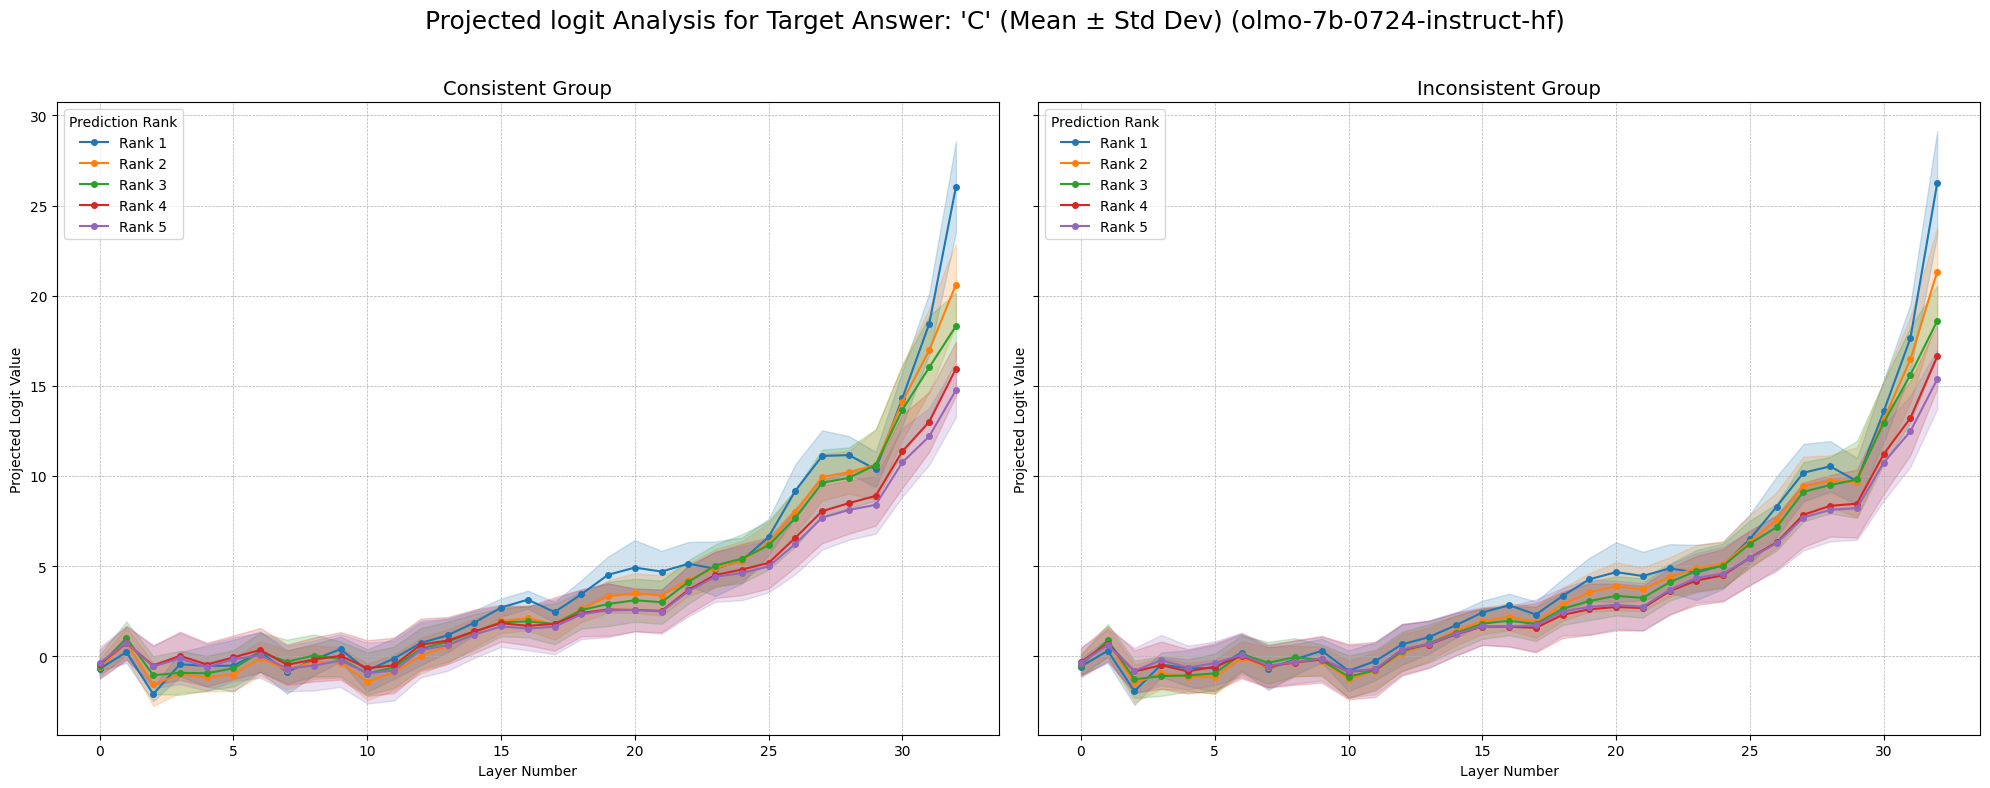

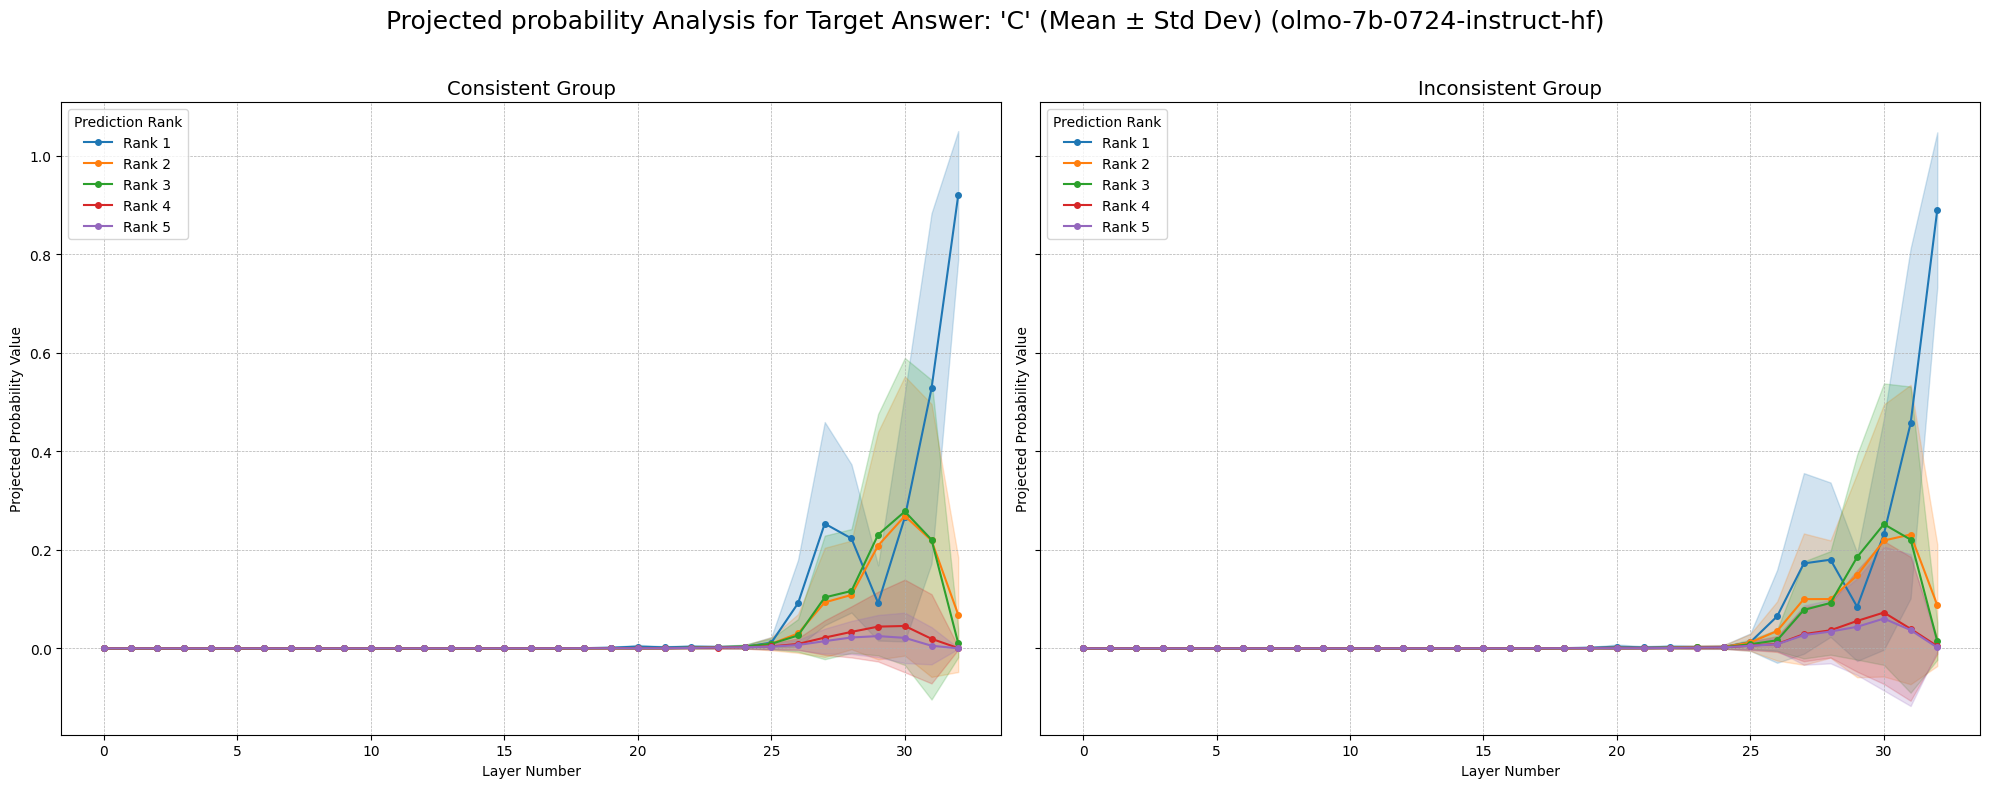

✅ Comparison plots for 'C' saved.

--- Analysis for Target Answer Group: 'D' ---
Found 183 consistent data points.
Found 31 inconsistent data points.


Analyzing consistent group for target 'D':   0%|          | 0/183 [00:00<?, ?it/s]

Analyzing inconsistent group for target 'D':   0%|          | 0/31 [00:00<?, ?it/s]

🎨 Plotting comparison with std dev for target answer 'D'...


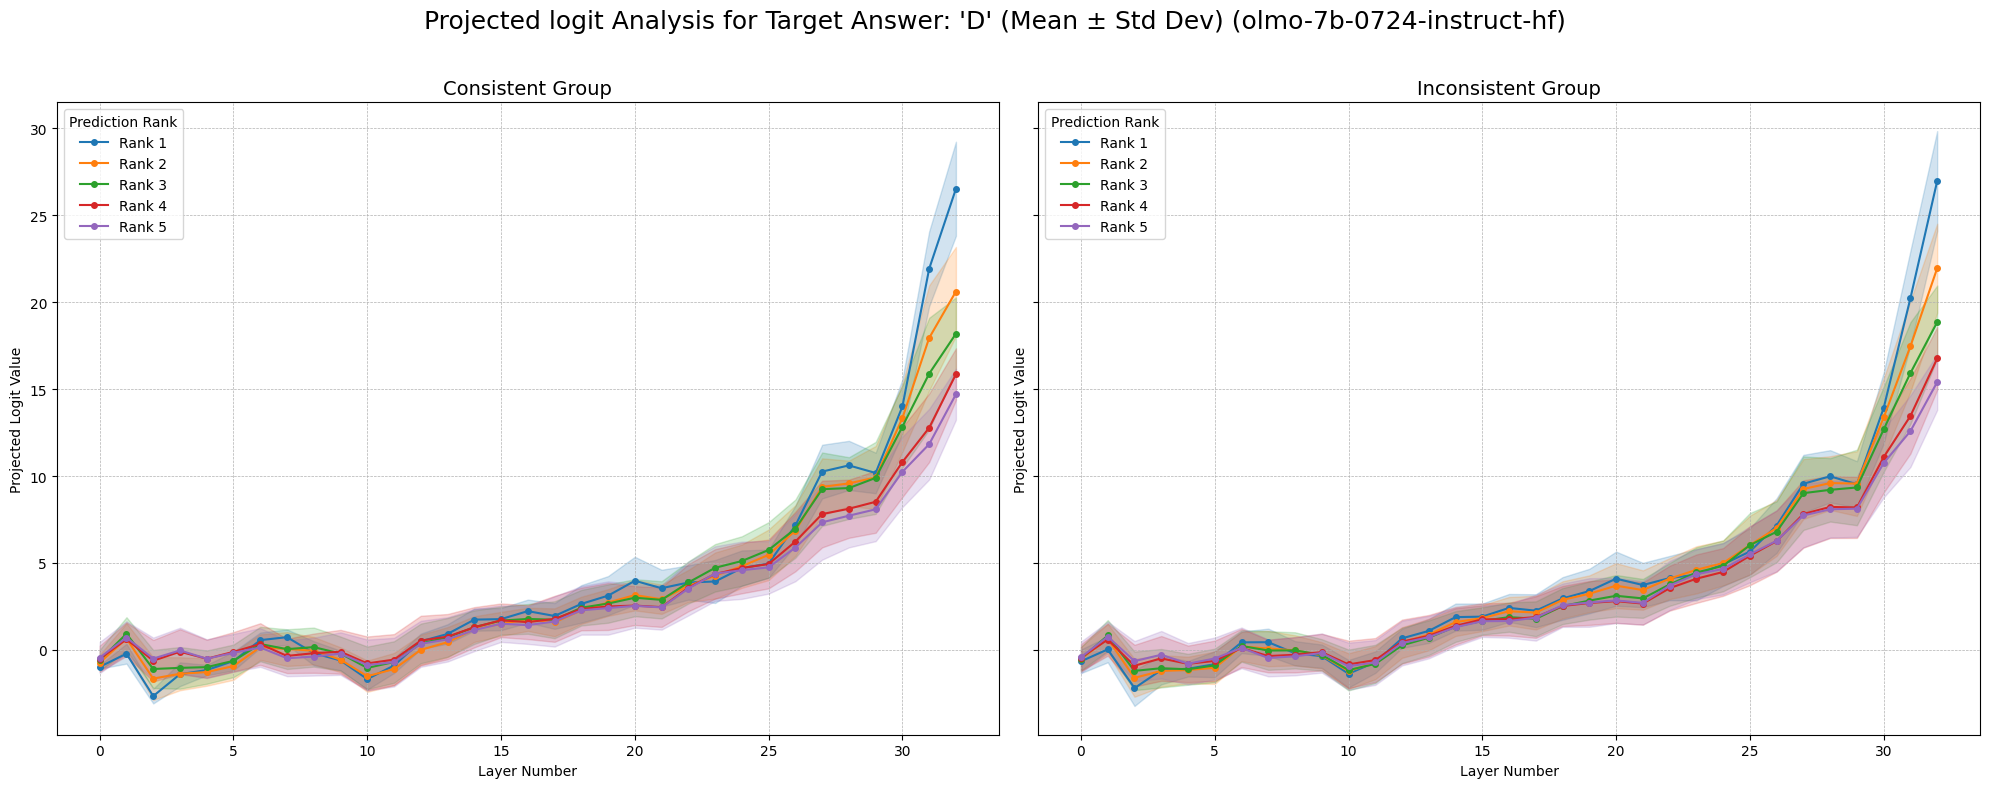

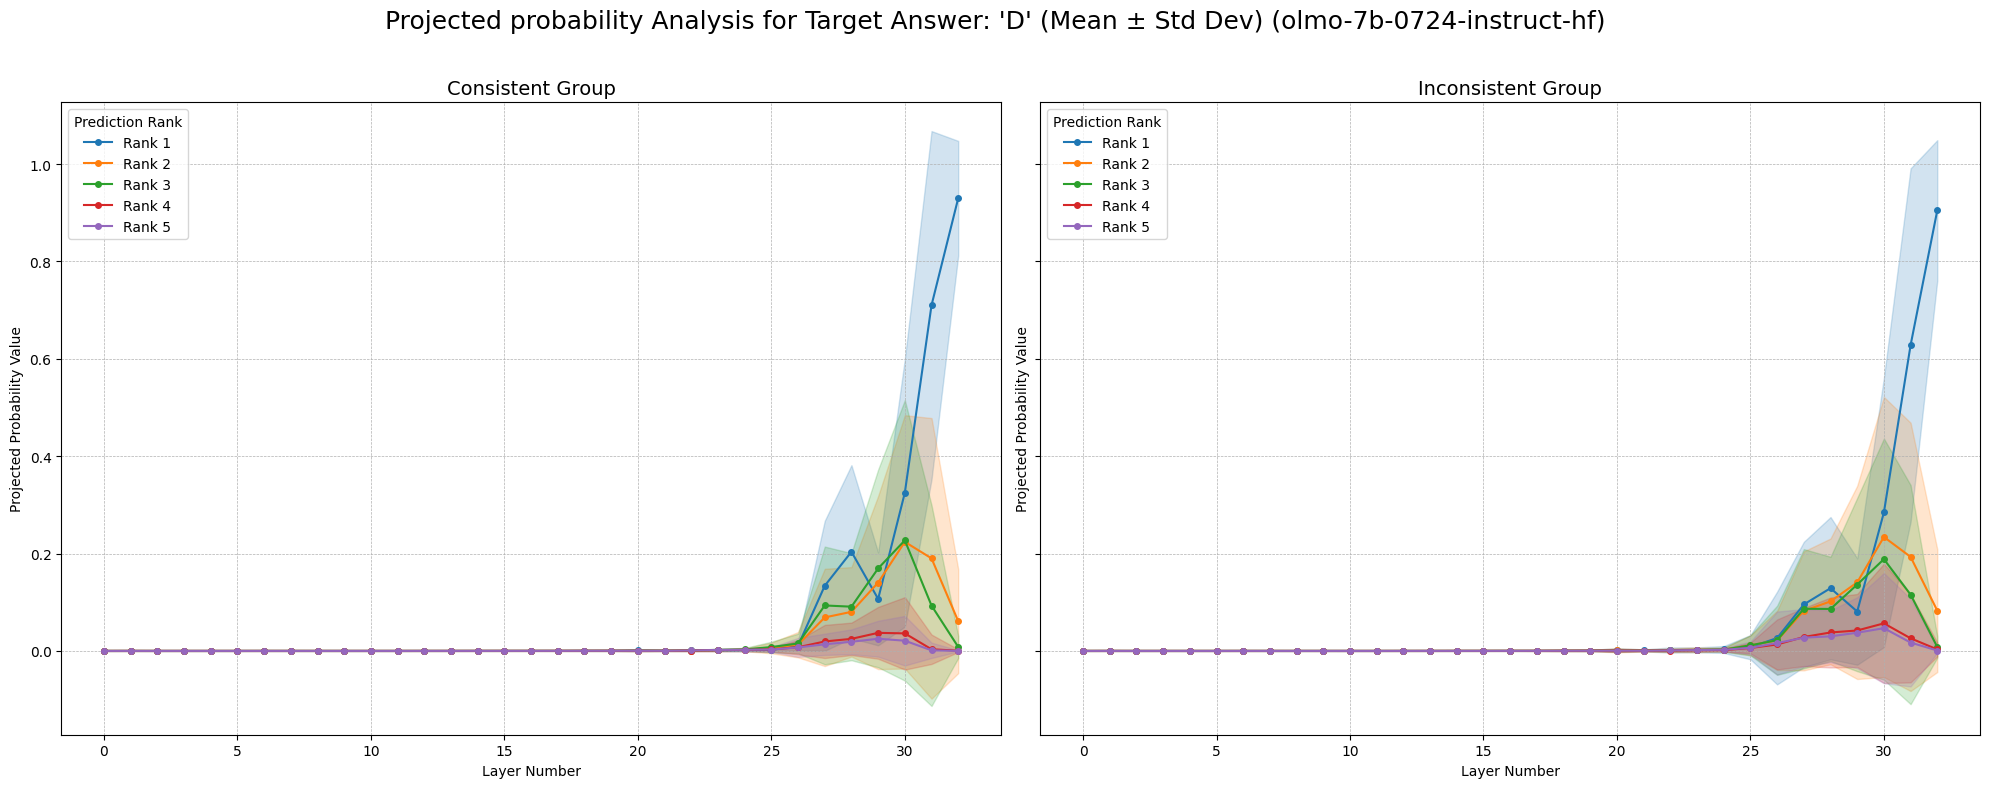

✅ Comparison plots for 'D' saved.

--- Analysis for Target Answer Group: 'E' ---
Found 135 consistent data points.
Found 45 inconsistent data points.


Analyzing consistent group for target 'E':   0%|          | 0/135 [00:00<?, ?it/s]

Analyzing inconsistent group for target 'E':   0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
if __name__ == '__main__':
    # --- Setup ---
    consistent_id_filepath = save_path + "/normalized_consistent_ids.json"
    inconsistent_id_filepath = save_path + "/normalized_inconsistent_ids.json"
    ilt_filepath = save_path + "/data_ilt.json"

    # --- 1. Load data ---
    print("Step 1: Loading all data files...")
    with open(consistent_id_filepath, 'r') as f:
        consistent_ids = json.load(f)
    with open(inconsistent_id_filepath, 'r') as f:
        inconsistent_ids = json.load(f)
    with open(ilt_filepath, 'r') as f:
        generated_answers = json.load(f)

    all_data_by_id = {}
    with jsonlines.open(dataset_path) as reader:
        for item in reader:
            if 'id' in item:
                all_data_by_id[item['id']] = item
    print("Data loading complete.")

    # --- 2. Define the set of possible answers for filtering data subsets ---
    # This list is used to create the groups (e.g., all consistent data where the answer was "A").
    # It is NOT used for tracking logits anymore.
    target_answer_tokens = ["A", "B", "C", "D", "E"]
    print(f"Will create data groups for target answers: {target_answer_tokens}")

    # --- 3. Run the new analysis pipeline ---
    # The pipeline is now called once and handles iterating through the target answers internally.
    main_analysis_pipeline(
        model=model,
        tokenizer=tokenizer,
        all_data_by_id=all_data_by_id,
        generated_answers=generated_answers,
        consistent_ids=consistent_ids,
        inconsistent_ids=inconsistent_ids,
        templates=prompts,
        target_answer_tokens=target_answer_tokens,
        device=device,
        k_value=5 # You can change this to track top 3, top 10, etc.
    )